# IoT Sensor Stream Simulation with Chronostore

In [1]:
import os
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from chronostore import TimeSeriesEngine, TableSchema, ColumnSchema
from chronostore.backend import FlatFileBackend

# Clean previous run
os.system("rm -rf ./data")

# Setup schema and engine
schema = TableSchema(columns=[
    ColumnSchema("timestamp", "q"),
    ColumnSchema("temperature", "d"),
    ColumnSchema("humidity", "d"),
])

backend = FlatFileBackend(schema, "./data")
engine = TimeSeriesEngine(backend)

# Simulate 7 days of IoT data, 1 reading every minute
start_date = datetime(2025, 6, 1, 0, 0)
minutes_per_day = 60 * 24
num_days = 7
total_rows = minutes_per_day * num_days

rows = []
for day_offset in range(num_days):
    base = start_date + timedelta(days=day_offset)
    for i in range(minutes_per_day):
        ts = int((base + timedelta(minutes=i)).timestamp() * 1e9)
        rows.append({
            "timestamp": ts,
            "temperature": random.uniform(18.0, 25.0),
            "humidity": random.uniform(30.0, 60.0),
        })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Append day by day (simulates live ingestion)
for day_str, group_df in df.groupby(df["timestamp"].map(
    lambda ts: datetime.utcfromtimestamp(ts / 1e9).strftime("%Y-%m-%d")
)):
    engine.append("Sensor1", day_str, group_df)

engine.flush()
print(f"Wrote {len(df):,} sensor entries across {num_days} days.")

Wrote 10,080 sensor entries across 7 days.


Total read: 9840
🌧️  High humidity on 2025-06-03: 228 entries


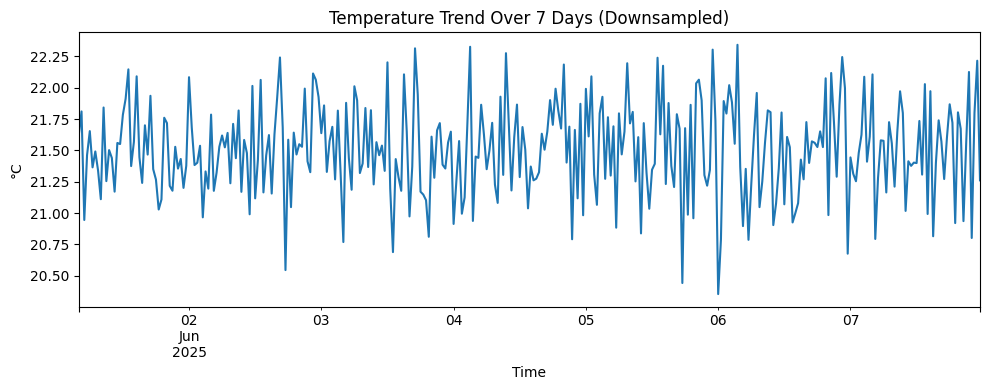

In [5]:
# Read entire range
full = engine.read_dataframe("Sensor1", ["2025-06-01", "2025-06-07"])
print("Total read:", len(full["timestamp"]))

# Filter: High humidity readings
humid = engine.read("Sensor1", "2025-06-03", where=lambda d: d["humidity"] > 55.0)
print(f"🌧️  High humidity on 2025-06-03: {len(humid['timestamp'])} entries")


# Downsample to 1 reading per 30 minutes
downsampled_df = pd.DataFrame({
    "timestamp": timestamps,
    "temperature": full["temperature"]
}).set_index("timestamp").resample("30min").mean()

# Plot a quick temperature trend
downsampled_df.plot(figsize=(10, 4), legend=False)
plt.title("Temperature Trend Over 7 Days (Downsampled)")
plt.xlabel("Time")
plt.ylabel("°C")
plt.tight_layout()
plt.show()